In [1]:
!pip install -q kaggle

In [2]:
!kaggle datasets download 'tolgadincer/labeled-chest-xray-images'

Dataset URL: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images
License(s): other
100% 1.17G/1.17G [00:59<00:00, 21.9MB/s]
100% 1.17G/1.17G [00:59<00:00, 21.0MB/s]


In [3]:
!pip install pywavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 58.0 MB/s eta 0:00:00


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/UnetModels/pywavelettedUnet.h5')

In [14]:
!mkdir dataset

In [15]:
!unzip /content/labeled-chest-xray-images.zip -d dataset/

Streaming output truncated to the last 5000 lines.
  inflating: dataset/chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: d

Preprocessed image shape: (1, 256, 256, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


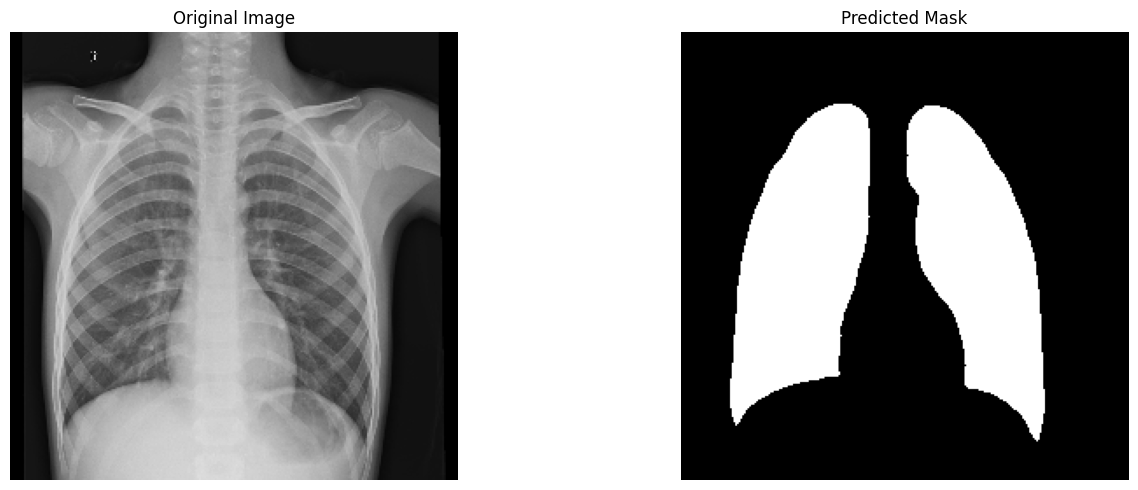

In [16]:
import numpy as np
import cv2
import os
import pywt
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score
import tensorflow as tf

def load_and_preprocess_image(image_path, wavelet='db4', image_size=(256, 256)):
    if not os.path.exists(image_path):
        raise ValueError(f"Image not found: {image_path}")

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image could not be loaded: {image_path}")

    img_resized = cv2.resize(img, image_size) / 255.0

    coeffs2 = pywt.dwt2(img_resized, wavelet)

    if coeffs2 is None or len(coeffs2) != 2:
        raise ValueError("Wavelet transformation failed to produce coefficients.")

    LL, (LH, HL, HH) = coeffs2

    LL = cv2.resize(LL, image_size)
    LH = cv2.resize(LH, image_size)
    HL = cv2.resize(HL, image_size)
    HH = cv2.resize(HH, image_size)

    wavelet_image = np.stack([LL, LH, HL, HH], axis=-1)

    return img_resized, wavelet_image


# Load and preprocess the image
image_path = "/content/dataset/chest_xray/test/NORMAL/NORMAL-1049278-0001.jpeg"  # Replace with your actual image path


original_image, preprocessed_image = load_and_preprocess_image(image_path)

# Add a batch dimension for model prediction
preprocessed_image_batch = np.expand_dims(preprocessed_image, axis=0)

print(f"Preprocessed image shape: {preprocessed_image_batch.shape}")

# Make prediction
predicted_mask = model.predict(preprocessed_image_batch)

# Ensure the predicted mask is binary
predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')


axes[1].imshow(predicted_mask_binary[0, :, :, 0], cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Calculate and print metrics
predicted_flat = predicted_mask_binary[0, :, :, 0].flatten()

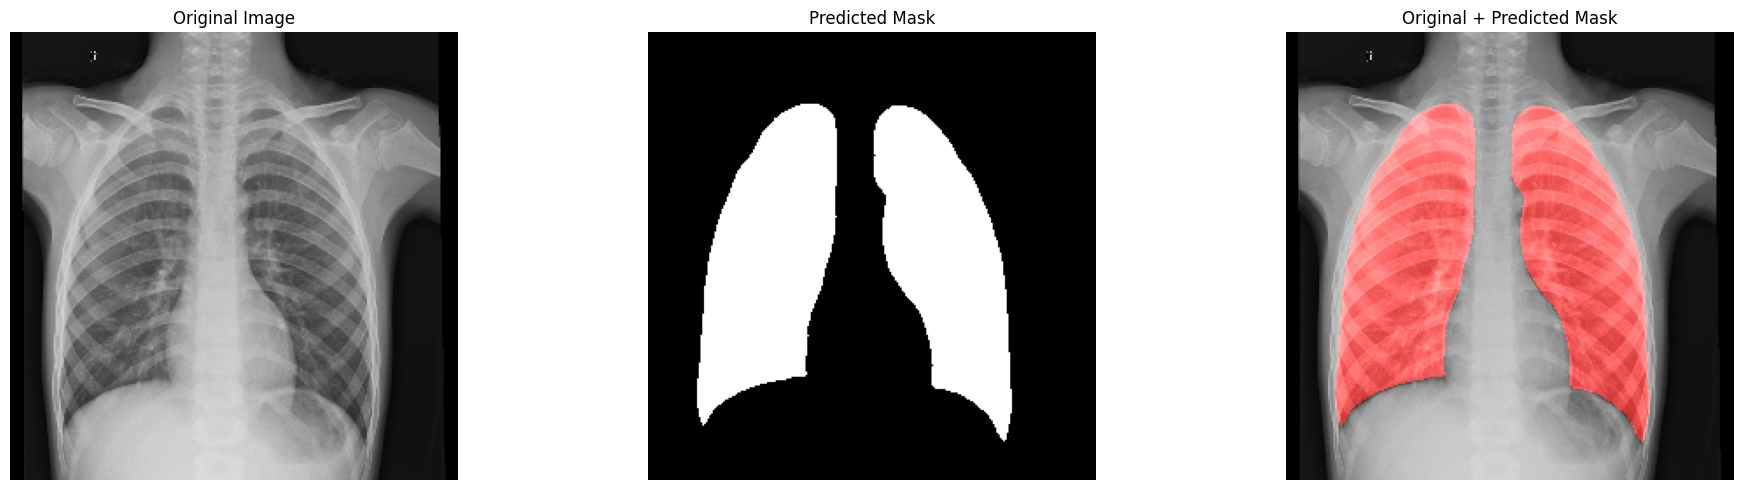

In [17]:
# Normalize original image back to range [0, 255] for visualization
original_image_uint8 = (original_image * 255).astype(np.uint8)

# Convert original grayscale image to 3-channel (RGB) image
original_image_rgb = np.stack([original_image_uint8] * 3, axis=-1)

# Convert predicted mask to 3-channel (RGB) image
predicted_mask_rgb = np.stack([predicted_mask_binary[0, :, :, 0]] * 3, axis=-1) * 255  # Scale to [0, 255]

# Color the mask red for better visualization (you can change the color if needed)
mask_color = np.zeros_like(predicted_mask_rgb)
mask_color[:, :, 0] = predicted_mask_binary[0, :, :, 0] * 255  # Red channel

# Overlay the mask on the original image (adjust alpha for transparency)
alpha = 0.6
overlay_image = cv2.addWeighted(original_image_rgb, 1, mask_color.astype(np.uint8), alpha, 0)

# Plot the original, predicted mask, and the combined overlay
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Original image
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Predicted mask
axes[1].imshow(predicted_mask_binary[0, :, :, 0], cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

# Combined overlay
axes[2].imshow(overlay_image)
axes[2].set_title('Original + Predicted Mask')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [18]:
import os
import numpy as np
import cv2
import pywt
import gc

def load_and_preprocess_image(image_path, wavelet='db4', image_size=(256, 256)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, image_size).astype(np.float32) / 255.0

    coeffs2 = pywt.dwt2(img_resized, wavelet)
    LL, (LH, HL, HH) = coeffs2

    wavelet_image = np.stack([
        cv2.resize(LL, image_size),
        cv2.resize(LH, image_size),
        cv2.resize(HL, image_size),
        cv2.resize(HH, image_size)
    ], axis=-1)

    return wavelet_image

def create_segmentation_masks(input_folder, output_folder, model, batch_size=32):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    image_paths = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]

    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []

        for image_path in batch_paths:
            try:
                preprocessed_image = load_and_preprocess_image(image_path)
                batch_images.append(preprocessed_image)
            except Exception as e:
                print(f"Error preprocessing {image_path}: {e}")

        if batch_images:
            batch_array = np.array(batch_images)

            try:
                predicted_masks = model.predict(batch_array)
                predicted_masks_binary = (predicted_masks > 0.5).astype(np.uint8)

                for j, mask in enumerate(predicted_masks_binary):
                    filename = os.path.basename(batch_paths[j])
                    mask_output_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_mask.png")
                    cv2.imwrite(mask_output_path, mask[:, :, 0] * 255)
                    print(f"Mask saved: {mask_output_path}")

            except Exception as e:
                print(f"Error processing batch: {e}")

            # Clear memory
            del batch_array, predicted_masks, predicted_masks_binary
            gc.collect()

        # Clear batch memory
        del batch_images
        gc.collect()

# Example usage
input_folder = "/content/dataset/chest_xray/train/NORMAL"
output_folder = "/content/dataset/chest_xray/train/NORMAL_masks"

create_segmentation_masks(input_folder, output_folder, model, batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step
Mask saved: /content/dataset/chest_xray/train/NORMAL_masks/NORMAL-3220570-0001_mask.png
Mask saved: /content/dataset/chest_xray/train/NORMAL_masks/NORMAL-4617560-0001_mask.png
Mask saved: /content/dataset/chest_xray/train/NORMAL_masks/NORMAL-7274749-0001_mask.png
Mask saved: /content/dataset/chest_xray/train/NORMAL_masks/NORMAL-8577633-0001_mask.png
Mask saved: /content/dataset/chest_xray/train/NORMAL_masks/NORMAL-7140141-0002_mask.png
Mask saved: /content/dataset/chest_xray/train/NORMAL_masks/NORMAL-5426353-0003_mask.png
Mask saved: /content/dataset/chest_xray/train/NORMAL_masks/NORMAL-5187821-0001_mask.png
Mask saved: /content/dataset/chest_xray/train/NORMAL_masks/NORMAL-1701841-0001_mask.png
Mask saved: /content/dataset/chest_xray/train/NORMAL_masks/NORMAL-3400382-0002_mask.png
Mask saved: /content/dataset/chest_xray/train/NORMAL_masks/NORMAL-3175147-0002_mask.png
Mask saved: /content/dataset/chest_xray/train/NORMAL_masks/NORMAL-5401202-0001_mas

In [19]:
# import os
# import numpy as np
# import cv2
# import pywt

# # Function to load and preprocess the image
# def load_and_preprocess_image(image_path, wavelet='db4', image_size=(256, 256)):
#     img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     img_resized = cv2.resize(img, image_size) / 255.0

#     coeffs2 = pywt.dwt2(img_resized, wavelet)
#     LL, (LH, HL, HH) = coeffs2

#     LL = cv2.resize(LL, image_size)
#     LH = cv2.resize(LH, image_size)
#     HL = cv2.resize(HL, image_size)
#     HH = cv2.resize(HH, image_size)

#     wavelet_image = np.stack([LL, LH, HL, HH], axis=-1)
#     return wavelet_image

# # Function to predict and save mask for each image
# def create_segmentation_masks(input_folder, output_folder, model):
#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)

#     # Loop through all images in the input folder
#     for filename in os.listdir(input_folder):
#         image_path = os.path.join(input_folder, filename)

#         if os.path.isfile(image_path):  # Only process files
#             try:
#                 # Load and preprocess image
#                 preprocessed_image = load_and_preprocess_image(image_path)
#                 preprocessed_image_batch = np.expand_dims(preprocessed_image, axis=0)

#                 # Predict the mask using the model
#                 predicted_mask = model.predict(preprocessed_image_batch)
#                 predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

#                 # Save the predicted mask as an image
#                 mask_output_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_mask.png")
#                 cv2.imwrite(mask_output_path, predicted_mask_binary[0, :, :, 0] * 255)
#                 print(f"Mask saved: {mask_output_path}")

#             except Exception as e:
#                 print(f"Error processing {filename}: {e}")

# # Example usage
# input_folder = "/content/dataset/chest_xray/test/NORMAL"  # Path to the folder containing images
# output_folder = "/content/dataset/chest_xray/train/NORMAL_masks"  # Folder to save the masks

# create_segmentation_masks(input_folder, output_folder, model)

In [20]:
input_folder = "/content/dataset/chest_xray/test/NORMAL"  # Path to the folder containing images
output_folder = "/content/dataset/chest_xray/test/NORMAL_masks"  # Folder to save the masks

create_segmentation_masks(input_folder, output_folder, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Mask saved: /content/dataset/chest_xray/test/NORMAL_masks/NORMAL-9104493-0001_mask.png
Mask saved: /content/dataset/chest_xray/test/NORMAL_masks/NORMAL-2107985-0001_mask.png
Mask saved: /content/dataset/chest_xray/test/NORMAL_masks/NORMAL-8207090-0001_mask.png
Mask saved: /content/dataset/chest_xray/test/NORMAL_masks/NORMAL-9334007-0001_mask.png
Mask saved: /content/dataset/chest_xray/test/NORMAL_masks/NORMAL-7165123-0001_mask.png
Mask saved: /content/dataset/chest_xray/test/NORMAL_masks/NORMAL-5401638-0001_mask.png
Mask saved: /content/dataset/chest_xray/test/NORMAL_masks/NORMAL-2798826-0001_mask.png
Mask saved: /content/dataset/chest_xray/test/NORMAL_masks/NORMAL-3293997-0001_mask.png
Mask saved: /content/dataset/chest_xray/test/NORMAL_masks/NORMAL-3397442-0001_mask.png
Mask saved: /content/dataset/chest_xray/test/NORMAL_masks/NORMAL-8661138-0001_mask.png
Mask saved: /content/dataset/chest_xray/test/NORMAL_masks/NORMAL-706052-0001_mask.png
Mask s

In [21]:
input_folder = "/content/dataset/chest_xray/test/PNEUMONIA"  # Path to the folder containing images
output_folder = "/content/dataset/chest_xray/test/PNEUMONIA_masks"  # Folder to save the masks

create_segmentation_masks(input_folder, output_folder, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Mask saved: /content/dataset/chest_xray/test/PNEUMONIA_masks/VIRUS-2040583-0001_mask.png
Mask saved: /content/dataset/chest_xray/test/PNEUMONIA_masks/VIRUS-4033321-0001_mask.png
Mask saved: /content/dataset/chest_xray/test/PNEUMONIA_masks/BACTERIA-8046863-0001_mask.png
Mask saved: /content/dataset/chest_xray/test/PNEUMONIA_masks/BACTERIA-4161430-0002_mask.png
Mask saved: /content/dataset/chest_xray/test/PNEUMONIA_masks/BACTERIA-8285922-0003_mask.png
Mask saved: /content/dataset/chest_xray/test/PNEUMONIA_masks/BACTERIA-4345731-0003_mask.png
Mask saved: /content/dataset/chest_xray/test/PNEUMONIA_masks/VIRUS-4405644-0001_mask.png
Mask saved: /content/dataset/chest_xray/test/PNEUMONIA_masks/BACTERIA-5757955-0001_mask.png
Mask saved: /content/dataset/chest_xray/test/PNEUMONIA_masks/VIRUS-4840553-0001_mask.png
Mask saved: /content/dataset/chest_xray/test/PNEUMONIA_masks/BACTERIA-5240350-0004_mask.png
Mask saved: /content/dataset/chest_xray/test/PNEUMONIA

In [22]:
input_folder = "/content/dataset/chest_xray/train/PNEUMONIA"  # Path to the folder containing images
output_folder = "/content/dataset/chest_xray/train/PNEUMONIA_masks"  # Folder to save the masks

create_segmentation_masks(input_folder, output_folder, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Mask saved: /content/dataset/chest_xray/train/PNEUMONIA_masks/VIRUS-671100-0006_mask.png
Mask saved: /content/dataset/chest_xray/train/PNEUMONIA_masks/BACTERIA-2065888-0003_mask.png
Mask saved: /content/dataset/chest_xray/train/PNEUMONIA_masks/BACTERIA-1950119-0005_mask.png
Mask saved: /content/dataset/chest_xray/train/PNEUMONIA_masks/BACTERIA-5434840-0001_mask.png
Mask saved: /content/dataset/chest_xray/train/PNEUMONIA_masks/BACTERIA-215369-0006_mask.png
Mask saved: /content/dataset/chest_xray/train/PNEUMONIA_masks/VIRUS-2427242-0005_mask.png
Mask saved: /content/dataset/chest_xray/train/PNEUMONIA_masks/BACTERIA-869984-0001_mask.png
Mask saved: /content/dataset/chest_xray/train/PNEUMONIA_masks/VIRUS-7890032-0001_mask.png
Mask saved: /content/dataset/chest_xray/train/PNEUMONIA_masks/BACTERIA-3395038-0001_mask.png
Mask saved: /content/dataset/chest_xray/train/PNEUMONIA_masks/BACTERIA-4394900-0004_mask.png
Mask saved: /content/dataset/chest_xray/trai

In [23]:
import shutil
folder_to_zip = '/content/dataset/'
output_zip = '/content/dataset.zip'

shutil.make_archive(output_zip.replace('.zip', ''), 'zip', folder_to_zip)
print("Folder zipped successfully!")

Folder zipped successfully!


In [26]:
import shutil

output_zip = '/content/dataset.zip'
drive_path = '/content/drive/My Drive/'

shutil.move(output_zip, drive_path)
print("Zip file moved to Google Drive!")

Zip file moved to Google Drive!


2nd Dataset Segment Extraction and multiplication

In [27]:
!kaggle datasets download "paultimothymooney/chest-xray-pneumonia"

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:49<00:00, 23.0MB/s]
100% 2.29G/2.29G [01:49<00:00, 22.6MB/s]


In [28]:
!unzip /content/chest-xray-pneumonia.zip -d dataset2/

Streaming output truncated to the last 5000 lines.
  inflating: dataset2/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: dataset2/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: dataset2/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: dataset2/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: dataset2/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: dataset2/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: dataset2/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: dataset2/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: dataset2/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: dataset2/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: dataset2/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: dataset2/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: dataset2/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: dataset2/chest_xray/train/NORMAL/IM-0445-0001.jpeg  


Checking on second dataset:


Preprocessed image shape: (1, 256, 256, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


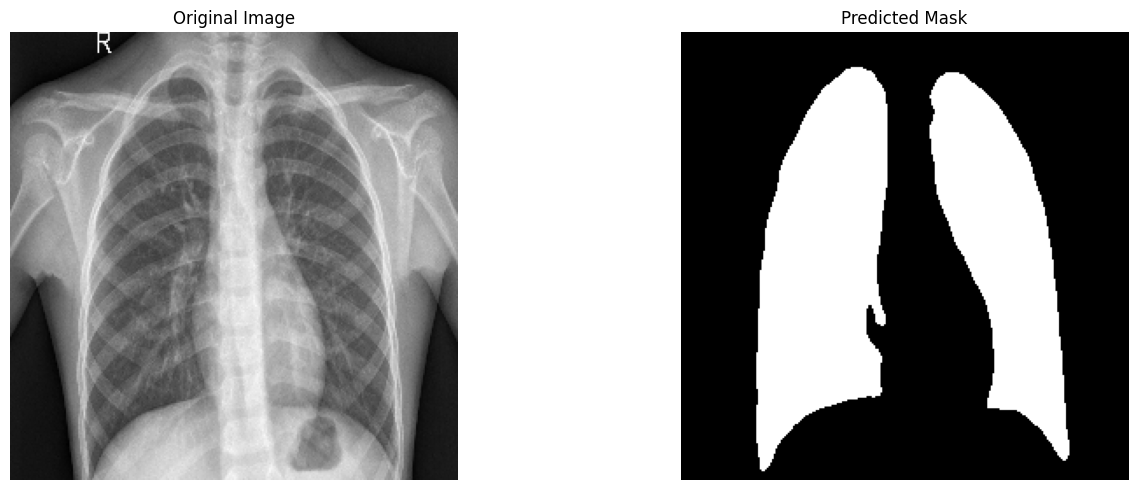

In [30]:
import numpy as np
import cv2
import os
import pywt
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score
import tensorflow as tf

def load_and_preprocess_image(image_path, wavelet='db4', image_size=(256, 256)):
    if not os.path.exists(image_path):
        raise ValueError(f"Image not found: {image_path}")

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image could not be loaded: {image_path}")

    img_resized = cv2.resize(img, image_size) / 255.0

    coeffs2 = pywt.dwt2(img_resized, wavelet)

    if coeffs2 is None or len(coeffs2) != 2:
        raise ValueError("Wavelet transformation failed to produce coefficients.")

    LL, (LH, HL, HH) = coeffs2

    LL = cv2.resize(LL, image_size)
    LH = cv2.resize(LH, image_size)
    HL = cv2.resize(HL, image_size)
    HH = cv2.resize(HH, image_size)

    wavelet_image = np.stack([LL, LH, HL, HH], axis=-1)

    return img_resized, wavelet_image


image_path = "/content/dataset2/chest_xray/test/NORMAL/IM-0001-0001.jpeg"


original_image, preprocessed_image = load_and_preprocess_image(image_path)

# Add a batch dimension for model prediction
preprocessed_image_batch = np.expand_dims(preprocessed_image, axis=0)

print(f"Preprocessed image shape: {preprocessed_image_batch.shape}")

# Make prediction
predicted_mask = model.predict(preprocessed_image_batch)

# Ensure the predicted mask is binary
predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')


axes[1].imshow(predicted_mask_binary[0, :, :, 0], cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Calculate and print metrics
predicted_flat = predicted_mask_binary[0, :, :, 0].flatten()

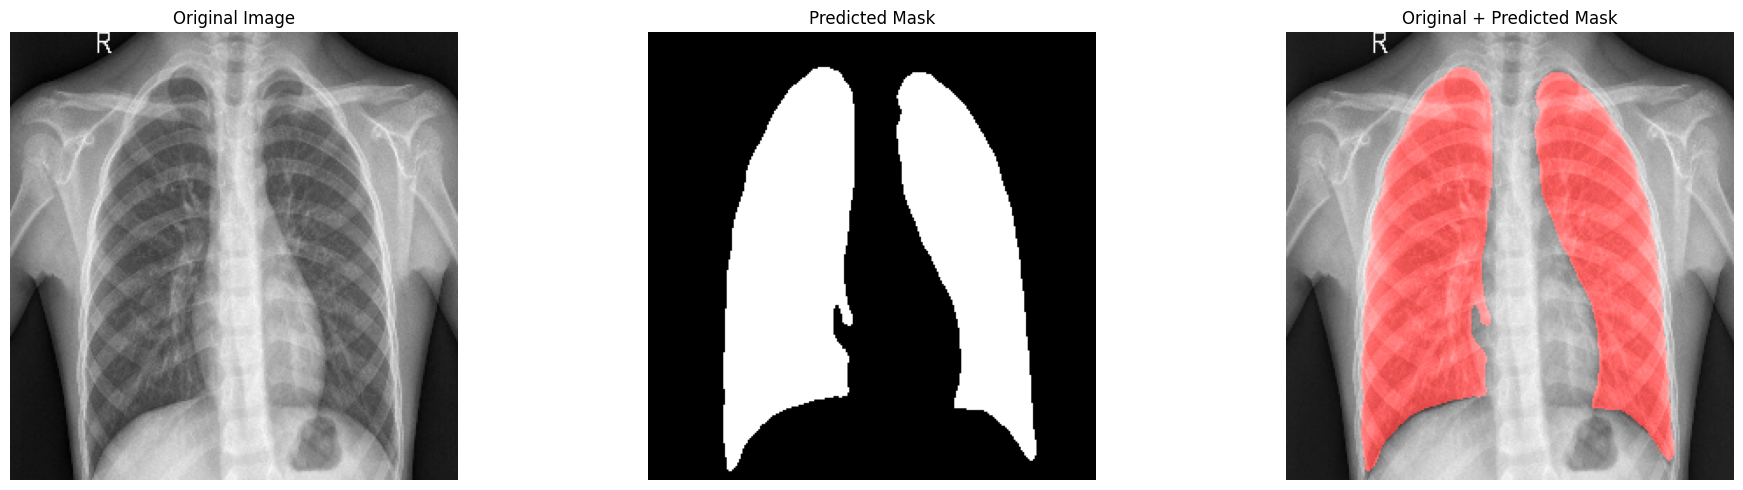

In [31]:
# Normalize original image back to range [0, 255] for visualization
original_image_uint8 = (original_image * 255).astype(np.uint8)

# Convert original grayscale image to 3-channel (RGB) image
original_image_rgb = np.stack([original_image_uint8] * 3, axis=-1)

# Convert predicted mask to 3-channel (RGB) image
predicted_mask_rgb = np.stack([predicted_mask_binary[0, :, :, 0]] * 3, axis=-1) * 255  # Scale to [0, 255]

# Color the mask red for better visualization (you can change the color if needed)
mask_color = np.zeros_like(predicted_mask_rgb)
mask_color[:, :, 0] = predicted_mask_binary[0, :, :, 0] * 255  # Red channel

# Overlay the mask on the original image (adjust alpha for transparency)
alpha = 0.6
overlay_image = cv2.addWeighted(original_image_rgb, 1, mask_color.astype(np.uint8), alpha, 0)

# Plot the original, predicted mask, and the combined overlay
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Original image
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Predicted mask
axes[1].imshow(predicted_mask_binary[0, :, :, 0], cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

# Combined overlay
axes[2].imshow(overlay_image)
axes[2].set_title('Original + Predicted Mask')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [35]:
import os
import numpy as np
import cv2
import pywt
import gc

def load_and_preprocess_image(image_path, wavelet='db4', image_size=(256, 256)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, image_size).astype(np.float32) / 255.0

    coeffs2 = pywt.dwt2(img_resized, wavelet)
    LL, (LH, HL, HH) = coeffs2

    wavelet_image = np.stack([
        cv2.resize(LL, image_size),
        cv2.resize(LH, image_size),
        cv2.resize(HL, image_size),
        cv2.resize(HH, image_size)
    ], axis=-1)

    return wavelet_image

def create_segmentation_masks(input_folder, output_folder, model, batch_size=32):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    image_paths = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]

    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []

        for image_path in batch_paths:
            try:
                preprocessed_image = load_and_preprocess_image(image_path)
                batch_images.append(preprocessed_image)
            except Exception as e:
                print(f"Error preprocessing {image_path}: {e}")

        if batch_images:
            batch_array = np.array(batch_images)

            print(f"Batch array shape: {batch_array.shape}")  # Added shape check

            try:
                predicted_masks = model.predict(batch_array)
                print(f"Predicted masks shape: {predicted_masks.shape}")  # Added shape check

                predicted_masks_binary = (predicted_masks > 0.5).astype(np.uint8)
                print(f"Binary masks shape: {predicted_masks_binary.shape}")  # Added shape check

                for j, mask in enumerate(predicted_masks_binary):
                    filename = os.path.basename(batch_paths[j])
                    mask_output_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_mask.png")
                    cv2.imwrite(mask_output_path, mask[:, :, 0] * 255)
                    print(f"Mask saved: {mask_output_path}")

            except Exception as e:
                print(f"Error processing batch: {e}")

            # Clear memory
            del batch_array, predicted_masks, predicted_masks_binary
            gc.collect()

        # Clear batch memory
        del batch_images
        gc.collect()

In [36]:
input_folder = "/content/dataset2/chest_xray/test/NORMAL"
output_folder = "/content/dataset2/chest_xray/test/NORMAL_masks/"

create_segmentation_masks(input_folder, output_folder, model)

Batch array shape: (32, 256, 256, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted masks shape: (32, 256, 256, 1)
Binary masks shape: (32, 256, 256, 1)
Mask saved: /content/dataset2/chest_xray/test/NORMAL_masks/NORMAL2-IM-0267-0001_mask.png
Mask saved: /content/dataset2/chest_xray/test/NORMAL_masks/NORMAL2-IM-0319-0001_mask.png
Mask saved: /content/dataset2/chest_xray/test/NORMAL_masks/NORMAL2-IM-0281-0001_mask.png
Mask saved: /content/dataset2/chest_xray/test/NORMAL_masks/IM-0017-0001_mask.png
Mask saved: /content/dataset2/chest_xray/test/NORMAL_masks/NORMAL2-IM-0372-0001_mask.png
Mask saved: /content/dataset2/chest_xray/test/NORMAL_masks/IM-0059-0001_mask.png
Mask saved: /content/dataset2/chest_xray/test/NORMAL_masks/NORMAL2-IM-0362-0001_mask.png
Mask saved: /content/dataset2/chest_xray/test/NORMAL_masks/NORMAL2-IM-0206-0001_mask.png
Mask saved: /content/dataset2/chest_xray/test/NORMAL_masks/IM-0003-0001_mask.png
Mask saved: /content/dataset2/chest_xray/test/NORMAL_masks/NORMAL2-IM

In [37]:
input_folder = "/content/dataset2/chest_xray/train/NORMAL/"  # Path to the folder containing images
output_folder = "/content/dataset2/chest_xray/train/NORMAL_masks/"  # Folder to save the masks

create_segmentation_masks(input_folder, output_folder, model)

Batch array shape: (32, 256, 256, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted masks shape: (32, 256, 256, 1)
Binary masks shape: (32, 256, 256, 1)
Mask saved: /content/dataset2/chest_xray/train/NORMAL_masks/IM-0164-0001_mask.png
Mask saved: /content/dataset2/chest_xray/train/NORMAL_masks/NORMAL2-IM-0390-0001_mask.png
Mask saved: /content/dataset2/chest_xray/train/NORMAL_masks/NORMAL2-IM-0651-0001_mask.png
Mask saved: /content/dataset2/chest_xray/train/NORMAL_masks/NORMAL2-IM-0879-0001_mask.png
Mask saved: /content/dataset2/chest_xray/train/NORMAL_masks/IM-0568-0001_mask.png
Mask saved: /content/dataset2/chest_xray/train/NORMAL_masks/NORMAL2-IM-0837-0001_mask.png
Mask saved: /content/dataset2/chest_xray/train/NORMAL_masks/IM-0499-0001_mask.png
Mask saved: /content/dataset2/chest_xray/train/NORMAL_masks/NORMAL2-IM-0841-0001_mask.png
Mask saved: /content/dataset2/chest_xray/train/NORMAL_masks/NORMAL2-IM-1206-0001_mask.png
Mask saved: /content/dataset2/chest_xray/train/NORMAL_masks/

In [38]:
input_folder = "/content/dataset2/chest_xray/test/PNEUMONIA/"  # Path to the folder containing images
output_folder = "/content/dataset2/chest_xray/test/PNEUMONIA_masks/"  # Folder to save the masks

create_segmentation_masks(input_folder, output_folder, model)

Batch array shape: (32, 256, 256, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted masks shape: (32, 256, 256, 1)
Binary masks shape: (32, 256, 256, 1)
Mask saved: /content/dataset2/chest_xray/test/PNEUMONIA_masks/person1667_virus_2881_mask.png
Mask saved: /content/dataset2/chest_xray/test/PNEUMONIA_masks/person22_virus_55_mask.png
Mask saved: /content/dataset2/chest_xray/test/PNEUMONIA_masks/person85_bacteria_423_mask.png
Mask saved: /content/dataset2/chest_xray/test/PNEUMONIA_masks/person122_bacteria_584_mask.png
Mask saved: /content/dataset2/chest_xray/test/PNEUMONIA_masks/person46_virus_96_mask.png
Mask saved: /content/dataset2/chest_xray/test/PNEUMONIA_masks/person83_bacteria_412_mask.png
Mask saved: /content/dataset2/chest_xray/test/PNEUMONIA_masks/person114_bacteria_545_mask.png
Mask saved: /content/dataset2/chest_xray/test/PNEUMONIA_masks/person108_bacteria_511_mask.png
Mask saved: /content/dataset2/chest_xray/test/PNEUMONIA_masks/person91_bacteria_446_mask.png
Mask saved: /c

In [ ]:
input_folder = "/content/dataset2/chest_xray/train/PNEUMONIA/"  # Path to the folder containing images
output_folder = "/content/dataset2/chest_xray/train/PNEUMONIA_masks/"  # Folder to save the masks

create_segmentation_masks(input_folder, output_folder, model)

Batch array shape: (32, 256, 256, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted masks shape: (32, 256, 256, 1)
Binary masks shape: (32, 256, 256, 1)
Mask saved: /content/dataset2/chest_xray/train/PNEUMONIA_masks/person1_bacteria_1_mask.png
Mask saved: /content/dataset2/chest_xray/train/PNEUMONIA_masks/person837_bacteria_2753_mask.png
Mask saved: /content/dataset2/chest_xray/train/PNEUMONIA_masks/person534_bacteria_2253_mask.png
Mask saved: /content/dataset2/chest_xray/train/PNEUMONIA_masks/person500_bacteria_2109_mask.png
Mask saved: /content/dataset2/chest_xray/train/PNEUMONIA_masks/person1298_virus_2228_mask.png
Mask saved: /content/dataset2/chest_xray/train/PNEUMONIA_masks/person998_bacteria_2927_mask.png
Mask saved: /content/dataset2/chest_xray/train/PNEUMONIA_masks/person707_bacteria_2606_mask.png
Mask saved: /content/dataset2/chest_xray/train/PNEUMONIA_masks/person596_virus_1149_mask.png
Mask saved: /content/dataset2/chest_xray/train/PNEUMONIA_masks/person162_virus_321_mask.

In [ ]:
input_folder = "/content/dataset2/chest_xray/val/NORMAL/"  # Path to the folder containing images
output_folder = "/content/dataset2/chest_xray/val/NORMAL_masks/"  # Folder to save the masks

create_segmentation_masks(input_folder, output_folder, model)

In [ ]:
input_folder = "/content/dataset2/chest_xray/val/PNEUMONIA/"  # Path to the folder containing images
output_folder = "/content/dataset2/chest_xray/val/PNEUMONIA_masks/"  # Folder to save the masks

create_segmentation_masks(input_folder, output_folder, model)

In [ ]:
import shutil
folder_to_zip = '/content/dataset2/'
output_zip = '/content/dataset2.zip'

shutil.make_archive(output_zip.replace('.zip', ''), 'zip', folder_to_zip)
print("Folder zipped successfully!")

In [ ]:
import shutil

output_zip = '/content/dataset2.zip'
drive_path = '/content/drive/My Drive/'

shutil.move(output_zip, drive_path)
print("Zip file moved to Google Drive!")